In [1]:
import numpy as np
import matplotlib.pyplot as plt
from oeshoot import narx
% matplotlib inline

# Generating dataset
The data set used for identification will be generated using the following equation:
$$
y[n] = 0.9048y[n-1] +0.4758 u[n-1]
$$
The system input $u[n]$ is generated such that each value is hold for ten samples and have Gaussian distribution with zero  mean and unitary variance. We generate 1000 samples, 700 will be used for training and 300 for validation.

In [2]:
# Define System
def system_equation(y, u):
    ynext = 0.9048*y + 0.4758*u
    return ynext

# System Parameters
N = 1
M = 1
Ny = 1
Nu = 1

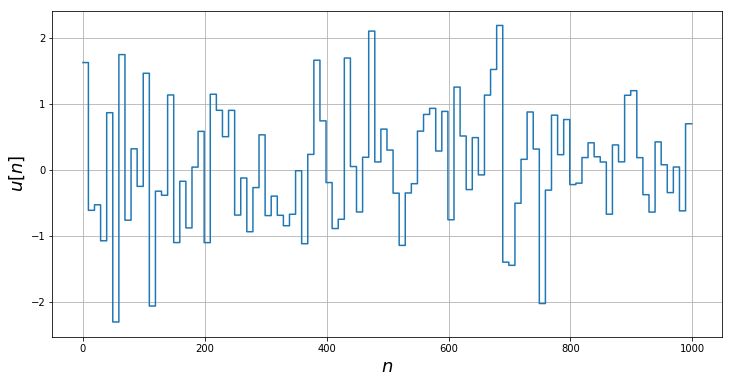

In [3]:
# Defining parameters
rept = 10
random_samples = 100
total_time = rept*random_samples

# Time vector
n = np.arange(0, total_time)

# Generating input
np.random.seed(1)
u = np.random.normal(size=(random_samples,)).repeat(rept)

n =  np.arange(len(u))

# Plot
_, ax = plt.subplots(figsize=(12, 6))
ax.step(n, u)
ax.set_xlabel("$n$", fontsize=18)
ax.set_ylabel("$u[n]$", fontsize=18)
ax.grid()
plt.show()

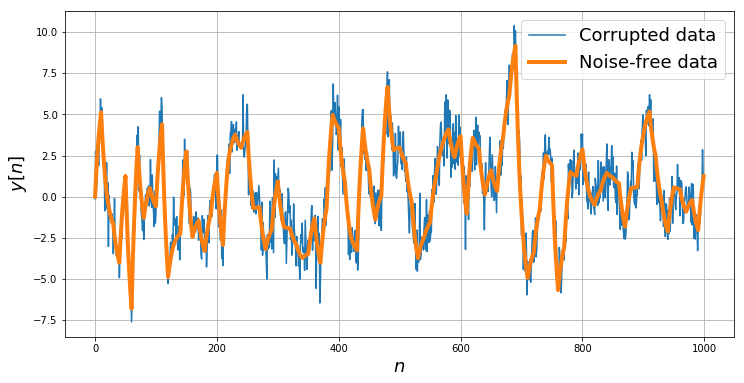

In [5]:
# Initialize input
ynoise_free = np.empty_like(u)

# Initial Conditions
y0 = 0

# Simulate it
ynoise_free[0] = y0
for i in range(1, len(ynoise_free)):
    ynoise_free[i] = system_equation(ynoise_free[i-1], u[i-1])
    
# Add output noise
v = np.random.normal(scale=1, size=ynoise_free.shape)
ynoisy = ynoise_free + v
n = np.arange(len(ynoisy))

# Separe in identification and validation datasets
Ni = 700
Nv = len(ynoisy) - Ny

# Identification data
yi = ynoisy[:Ni]
ui = u[:Ni]

# Validation data
yv = ynoisy[Ni:]
uv = u[Ni:]

# Plot
_, ax = plt.subplots(figsize=(12, 6))
ax.plot(n, ynoisy, label='Corrupted data')
ax.plot(n, ynoise_free, label='Noise-free data', lw=4)
ax.set_xlabel("$n$", fontsize=18)
ax.set_ylabel("$y[n]$", fontsize=18)
ax.grid()
ax.legend(fontsize=18)
plt.show()

# Estimate OE model
A linear model:
$$y[n] = a*y[n-1]+b*u[n-1]$$
will be fit to the identification data, minimizing simulation error. We use multiple shooting to estimate the parameters. We subdivide the training dataset containing 700 sample in 70 intervals, each containing 10 samples (``maxlength=10``). In this case I do not see much advantage in using the multiple shooting algorithm.

In [13]:
# Linear model
mdl = narx.Linear(N=1, M=1)

# Reshape data
yi = yi.reshape((-1, 1))
ui = ui.reshape((-1, 1))
yv = yv.reshape((-1, 1))
uv = uv.reshape((-1, 1))

# Define Simulation Error
sim_error = narx.SimulationError(mdl, yi, ui, maxlength=10)
predict_error = narx.PredictionError(mdl, yi, ui)

# Get initial guess for the parameters
initial_guess = [0, 0]

# Solve Optimization Problem
params, info = sim_error.lsq_estimate_parameters(initial_guess, max_nfev=100)

# Validation

Simulate data on validation interval

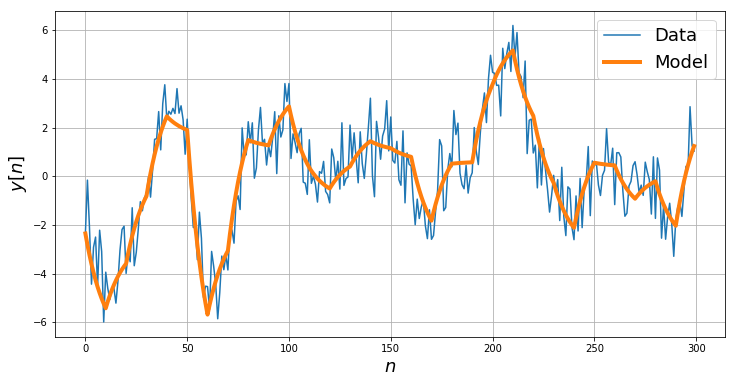

In [14]:
ys = narx.simulate(mdl, [[yv[0, 0]]], uv, params)
ys = np.hstack(([yv[0, 0]], ys[:-1].flatten()))
# Plot
_, ax = plt.subplots(figsize=(12, 6))
ax.plot(yv, label='Data')
ax.plot(ys, label='Model', lw=4)
ax.set_xlabel("$n$", fontsize=18)
ax.set_ylabel("$y[n]$", fontsize=18)
ax.grid()
ax.legend(fontsize=18)
plt.show()